## Cancer Diagnosis Capstone Project Modeling

The purpose of this part of the project is to use different modeling methods in order to determine if there is a model that performs better than the Logistic Regression baseline model in predicting whether a breast cancer tumor is benign or malignant.  To recap, two datasets are being compared.  The first is the dataset with all of the original variables, with an exception of perimeter mean and area mean, because they are direct correlations to radius.  The second is the dataset with all of the highly correlated variables used.  This only leaves five variables, which are: <br>
radius mean<br>
texture mean<br>
smoothness mean<br>
area standard error<br>
concavity standard error

Both of these models will be used throughout.  The models that are going to be used are (with the different hyperparameters that will be compared using GridSearchCV):<br>
**K-Nearest Neighbors (KNN)** <br>
Number of Neighbors: Range from 1-10 <br>
P (Power parameter for the Minkowski metric): 1(Manhattan Distance), 2(Euclidean Distance)<br>
Weights: Uniform or distance

**Random Forest Classification** <br>
Number of estimators: 100, 200, 300, 400, 500 <br>
Max depth: 10, 30, 50 <br>
Max features: auto, sqrt, log2

**XGBoost Classification** <br>
Learning rate (eta) : 0.01, 0.1, 1 <br>
Max depth: 2, 5, 10 <br>
Number of Estimators: 2, 5, 10 

After the best hyperparameters are found and each model is run, we will then test the performance of the model using an accuracy score, a confusion matrix, an roc curve, finding the area under the curve(AUC), and looking at the classification report.  These are the scores that will be compared to the baseline model.

The ideal targeted metrics are: <br>
1. Accuracy of at least 97% <br>
2. Less than 2 % false negatives <br>
3. A recall of at least 95% <br>
4. AUC of at least 99%


#### Importing and examining the data

I will first import anything that I need, including the same split data that was used in the baseline model. 

In [1]:
#Import everything that I plan on using during this project
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

#Import models that I want to use
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Import scoring methods for the models
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import classification_report

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import all of the models that will be used, starting with the models of the full data
X_train_f = pd.read_csv('X_train_f.csv', index_col=0)
X_test_f = pd.read_csv('X_test_f.csv', index_col=0)
y_train_f = pd.read_csv('y_train_f.csv', index_col=0)
y_test_f = pd.read_csv('y_test_f.csv', index_col=0)

#Now the partial data
X_train_p = pd.read_csv('X_train_p.csv', index_col=0)
X_test_p = pd.read_csv('X_test_p.csv', index_col=0)
y_train_p = pd.read_csv('y_train_p.csv', index_col=0)
y_test_p = pd.read_csv('y_test_p.csv', index_col=0)

In [3]:
X_train_f.shape, X_test_f.shape

((455, 28), (114, 28))

In [4]:
y_train_f.shape, y_test_f.shape

((455, 1), (114, 1))

In [5]:
X_train_p.shape, X_test_p.shape

((455, 5), (114, 5))

In [6]:
y_train_p.shape, y_test_p.shape

((455, 1), (114, 1))

#### Modeling with KNN

The numbers look accurate, so now it's time to model.  For each model, I will first run GridSearchCV with a variety of hyperparameter options to see which is the best for the full variables and partial variables.  I will take those hyperparameters and run them with each model, and then score them.  These will be compared to the ideal target metrics to find the best model.

We will start with KNN. As a refresher, the hyperparameters used are:<br>
Number of Neighbors: Range from 1-10 <br>
P (Power parameter for the Minkowski metric): 1(Manhattan Distance), 2(Euclidean Distance)<br>
Weights: Uniform or distance

In [7]:
#First run KNN for the full model
knn = KNeighborsClassifier()
n_neighbors = list(range(1,10))
param_knn= {'n_neighbors':n_neighbors, 'p':[1,2],'weights':['uniform','distance']}

gs_knn_f = GridSearchCV(knn, param_knn, cv=5, n_jobs=-1)
gs_knn_f.fit(X_train_f, y_train_f)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [8]:
gs_knn_f.best_params_

{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

In [9]:
knn_f = KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')
model_knn_f = knn_f.fit(X_train_f,y_train_f)
y_pred_knn_f = model_knn_f.predict(X_test_f)
accuracy_score_knn_f = accuracy_score(y_test_f, y_pred_knn_f)
accuracy_score_knn_f

0.956140350877193

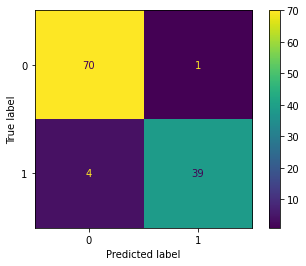

In [10]:
#Confussion matrix
knn_f_confusion_matrix = plot_confusion_matrix(model_knn_f, X_test_f, y_test_f)
knn_f_confusion_matrix

In [11]:
#Create a function for plotting ROC curve that can be used multiple times.
def plot_roc_curve(y_test, y_pred_prob, title, label=None):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title(title,fontsize=15)
    plt.show()

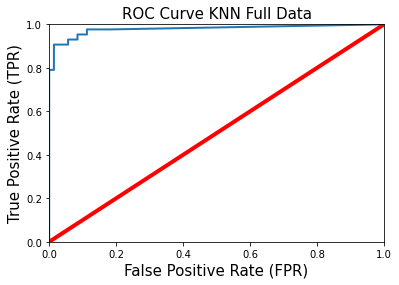

In [12]:
#plot the ROC curve
y_pred_prob_knn_f = knn_f.predict_proba(X_test_f)[:,1]
plot_roc_curve(y_test_f,y_pred_prob_knn_f,'ROC Curve KNN Full Data')

In [13]:
#Calculate the area under the curve.
roc_score_knn_f = roc_auc_score(y_test_f, y_pred_prob_knn_f)
print("AUC: ", roc_score_knn_f)

AUC:  0.9787094660989191


In [14]:
# Classification report, with a focus on recall
class_rep_knn_f = classification_report(y_test_f, y_pred_knn_f)
print(class_rep_knn_f)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        71
           1       0.97      0.91      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



None of these metrics reached the ideal threshold and did not even reach the logistic regression base model numbers.  We will also run the tests with the partial dataset, starting with reruning the GridSearchCV in case the ideal parameters are different.

In [15]:
knn = KNeighborsClassifier()

gs_knn_p = GridSearchCV(knn, param_knn, cv=5, n_jobs=-1)
gs_knn_p.fit(X_train_p, y_train_p)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [16]:
gs_knn_p.best_params_

{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [17]:
knn_p = KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')
model_knn_p = knn_p.fit(X_train_p,y_train_p)
y_pred_knn_p = model_knn_p.predict(X_test_p)
accuracy_score_knn_p = accuracy_score(y_test_p, y_pred_knn_p)
accuracy_score_knn_p

0.9122807017543859

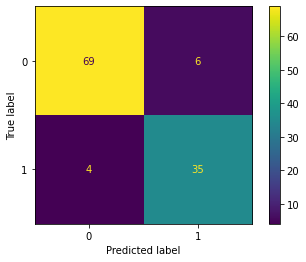

In [18]:
#Confussion matrix
knn_p_confusion_matrix = plot_confusion_matrix(model_knn_p, X_test_p, y_test_p)
knn_p_confusion_matrix

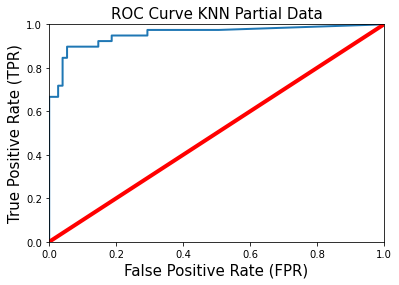

In [19]:
#plot the ROC curve
y_pred_prob_knn_p = knn_p.predict_proba(X_test_p)[:,1]
plot_roc_curve(y_test_p,y_pred_prob_knn_p,'ROC Curve KNN Partial Data')

In [20]:
#Calculate the area under the curve.
roc_score_knn_p = roc_auc_score(y_test_p, y_pred_prob_knn_p)
print("AUC: ", roc_score_knn_p)

AUC:  0.9553846153846153


In [21]:
# Classification report, with a focus on recall
class_rep_knn_p = classification_report(y_test_p, y_pred_knn_p)
print(class_rep_knn_p)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93        75
           1       0.85      0.90      0.88        39

    accuracy                           0.91       114
   macro avg       0.90      0.91      0.90       114
weighted avg       0.91      0.91      0.91       114



These numbers are even worse.  We will visualize the numbers later, but none of the numbers looked to be as good as the baseline model.  We will run the Random Forest modeling.

#### Modeling with Random Forest Classifier

Now to model with Random Forest Classifier.  Both partial and full data will be analyzed, and GridSearchCV will be run to find the optimal hyperparameters.  As a refresher, the hyperparameters used are:<br>
Number of estimators: 100, 200, 300, 400, 500 <br>
Max depth: 10, 30, 50 <br>
Max features: auto, sqrt, log2

In [22]:
#First run Random Forest for the full model
rf = RandomForestClassifier()
param_rf= {'n_estimators':[100,200,300,400,500], 'max_depth':[10,30,50],'max_features':['auto','sqrt','log2']}

gs_rf_f = GridSearchCV(rf, param_rf, cv=5, n_jobs=-1)
gs_rf_f.fit(X_train_f, y_train_f)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 30, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [23]:
gs_rf_f.best_params_

{'max_depth': 30, 'max_features': 'log2', 'n_estimators': 300}

In [24]:
rf_f = RandomForestClassifier(n_estimators=100, max_features='auto',max_depth=10)
model_rf_f = rf_f.fit(X_train_f,y_train_f)
y_pred_rf_f = model_rf_f.predict(X_test_f)
accuracy_score_rf_f = accuracy_score(y_test_f, y_pred_rf_f)
accuracy_score_rf_f

0.9649122807017544

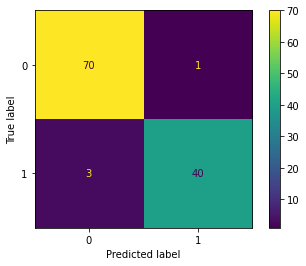

In [25]:
#Confussion matrix
rf_f_confusion_matrix = plot_confusion_matrix(model_rf_f, X_test_f, y_test_f)
rf_f_confusion_matrix

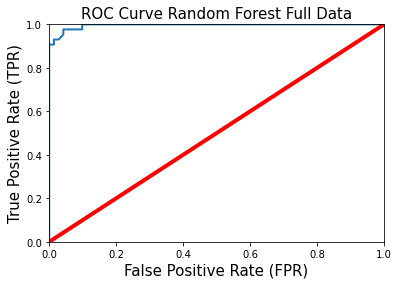

In [26]:
#plot the ROC curve
y_pred_prob_rf_f = rf_f.predict_proba(X_test_f)[:,1]
plot_roc_curve(y_test_f,y_pred_prob_rf_f,'ROC Curve Random Forest Full Data')

In [27]:
#Calculate the area under the curve.
roc_score_rf_f = roc_auc_score(y_test_f, y_pred_prob_rf_f)
print("AUC: ", roc_score_rf_f)

AUC:  0.9955781198820832


In [28]:
# Classification report, with a focus on recall
class_rep_rf_f = classification_report(y_test_f, y_pred_rf_f)
print(class_rep_rf_f)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



The numbers look at little better than KNN but not as good as the baseline model.  It will be easier to compare visually later.  Now let's look at the Random Forest with the partial data.

In [29]:
rf_p = RandomForestClassifier()

#Using same parameters as the full model
gs_rf_p = GridSearchCV(rf_p, param_rf, cv=5, n_jobs=-1)
gs_rf_p.fit(X_train_p, y_train_p)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 30, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [30]:
gs_rf_p.best_params_

{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 300}

In [31]:
rf_p = RandomForestClassifier(n_estimators=300, max_features='sqrt',max_depth=10)
model_rf_p = rf_p.fit(X_train_p,y_train_p)
y_pred_rf_p = model_rf_p.predict(X_test_p)
accuracy_score_rf_p = accuracy_score(y_test_p, y_pred_rf_p)
accuracy_score_rf_p

0.9210526315789473

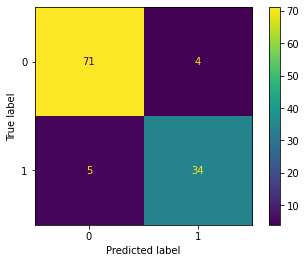

In [32]:
#Confussion matrix
rf_p_confusion_matrix = plot_confusion_matrix(model_rf_p, X_test_p, y_test_p)
rf_p_confusion_matrix

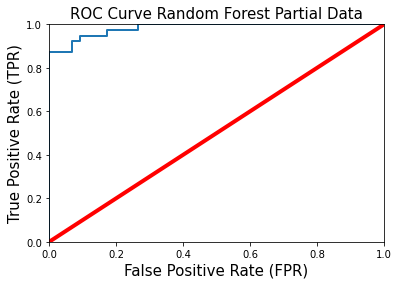

In [33]:
#plot the ROC curve
y_pred_prob_rf_p = rf_p.predict_proba(X_test_p)[:,1]
plot_roc_curve(y_test_p,y_pred_prob_rf_p,'ROC Curve Random Forest Partial Data')

In [34]:
#Calculate the area under the curve.
roc_score_rf_p = roc_auc_score(y_test_p, y_pred_prob_rf_p)
print("AUC: ", roc_score_rf_p)

AUC:  0.982905982905983


In [35]:
# Classification report, with a focus on recall
class_rep_rf_p = classification_report(y_test_p, y_pred_rf_p)
print(class_rep_rf_p)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        75
           1       0.89      0.87      0.88        39

    accuracy                           0.92       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114



The important numbers got lower.  While feature importances couldn't be found on KNN, it can be found on Random Forest. Lets examine that before moving on to the next model.

Text(0.5, 1.0, 'Feature Importance for Random Forest Full')

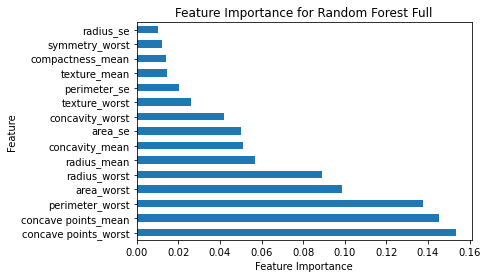

In [36]:
feat_importances_rf_f = pd.Series(model_rf_f.feature_importances_, index=X_train_f.columns)
feat_importances_rf_f.nlargest(15).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title("Feature Importance for Random Forest Full")

Text(0.5, 1.0, 'Feature Importance for Random Forest Partial')

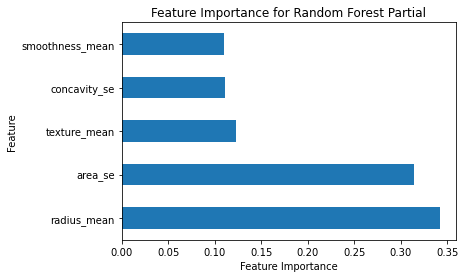

In [37]:
feat_importances_rf_p = pd.Series(model_rf_p.feature_importances_, index=X_train_p.columns)
feat_importances_rf_p.nlargest(5).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title("Feature Importance for Random Forest Partial")

It is interesting to note that a lot of the higher importance features in the full model were in the "worst" category, when I removed all of those from the reduced dataset.

#### Modeling with XGBoost

Now to model with XGBoost.  Both partial and full data will be analyzed, and GridSearchCV will be run to find the optimal hyperparameters.  As a refresher, the hyperparameters used are:<br>
Learning rate (eta) : 0.01, 0.1, 1 <br>
Max depth: 2, 5, 10 <br>
Number of Estimators: 2, 5, 10 

In [38]:
#First run XGBoost for the full model
xgb = XGBClassifier()
param_xgb= {'learning_rate':[0.01,0.1,1], 'max_depth':[2,5,10],'n_estimators':[2,5,10]}

gs_xgb_f = GridSearchCV(xgb, param_xgb, cv=5, n_jobs=-1)
gs_xgb_f.fit(X_train_f, y_train_f)

[14:09:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [39]:
gs_xgb_f.best_params_

{'learning_rate': 1, 'max_depth': 2, 'n_estimators': 10}

In [40]:
xgb_f = XGBClassifier(n_estimators=10, learning_rate=1,max_depth=2)
model_xgb_f = xgb_f.fit(X_train_f,y_train_f)
y_pred_xgb_f = model_xgb_f.predict(X_test_f)
accuracy_score_xgb_f = accuracy_score(y_test_f, y_pred_xgb_f)
accuracy_score_xgb_f

[14:09:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9736842105263158

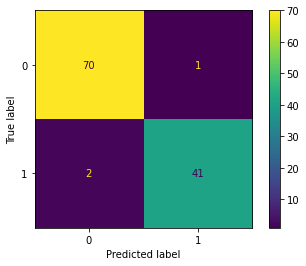

In [41]:
#Confussion matrix
xgb_f_confusion_matrix = plot_confusion_matrix(model_xgb_f, X_test_f, y_test_f)
xgb_f_confusion_matrix

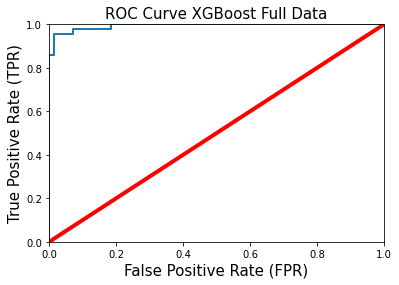

In [42]:
#plot the ROC curve
y_pred_prob_xgb_f = xgb_f.predict_proba(X_test_f)[:,1]
plot_roc_curve(y_test_f,y_pred_prob_xgb_f,'ROC Curve XGBoost Full Data')

In [43]:
#Calculate the area under the curve.
roc_score_xgb_f = roc_auc_score(y_test_f, y_pred_prob_xgb_f)
print("AUC: ", roc_score_xgb_f)

AUC:  0.9927939731411726


In [44]:
# Classification report, with a focus on recall
class_rep_xgb_f = classification_report(y_test_f, y_pred_xgb_f)
print(class_rep_xgb_f)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



This is the most comparable to the baseline model so far.  Let's look at the XGBoost with the partial data.

In [45]:
xgb = XGBClassifier()

#Using same parameters as full model
gs_xgb_p = GridSearchCV(xgb, param_xgb, cv=5, n_jobs=-1)
gs_xgb_p.fit(X_train_p, y_train_p)

[14:09:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [46]:
gs_xgb_p.best_params_

{'learning_rate': 1, 'max_depth': 2, 'n_estimators': 5}

In [47]:
xgb_p = XGBClassifier(n_estimators=5, learning_rate=1,max_depth=2)
model_xgb_p = xgb_p.fit(X_train_p,y_train_p)
y_pred_xgb_p = model_xgb_p.predict(X_test_p)
accuracy_score_xgb_p = accuracy_score(y_test_p, y_pred_xgb_p)
accuracy_score_xgb_p

[14:09:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9035087719298246

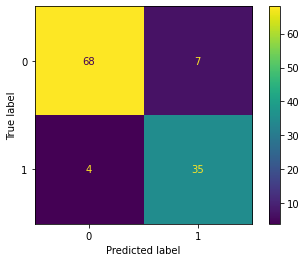

In [48]:
#Confussion matrix
xgb_p_confusion_matrix = plot_confusion_matrix(model_xgb_p, X_test_p, y_test_p)
xgb_p_confusion_matrix

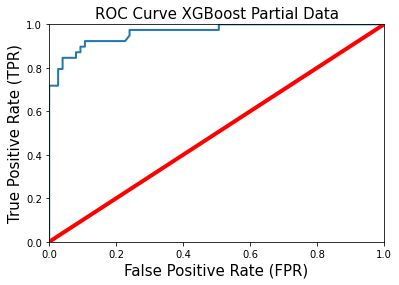

In [49]:
#plot the ROC curve
y_pred_prob_xgb_p = xgb_p.predict_proba(X_test_p)[:,1]
plot_roc_curve(y_test_p,y_pred_prob_xgb_p,'ROC Curve XGBoost Partial Data')

In [50]:
#Calculate the area under the curve.
roc_score_xgb_p = roc_auc_score(y_test_p, y_pred_prob_xgb_p)
print("AUC: ", roc_score_xgb_p)

AUC:  0.9635897435897436


In [51]:
# Classification report, with a focus on recall
class_rep_xgb_p = classification_report(y_test_p, y_pred_xgb_p)
print(class_rep_xgb_p)

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        75
           1       0.83      0.90      0.86        39

    accuracy                           0.90       114
   macro avg       0.89      0.90      0.89       114
weighted avg       0.91      0.90      0.90       114



The scoring does not look as good as with the full data, but that has been pretty consisten throughout.  Let's compare the feature importance.

Text(0.5, 1.0, 'Feature Importance for XGBoost Full')

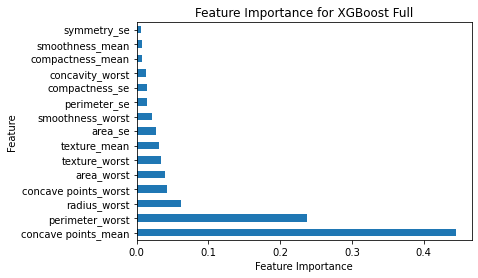

In [52]:
feat_importances_xgb_f = pd.Series(model_xgb_f.feature_importances_, index=X_train_f.columns)
feat_importances_xgb_f.nlargest(15).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title("Feature Importance for XGBoost Full")

Text(0.5, 1.0, 'Feature Importance for XGBoost Partial')

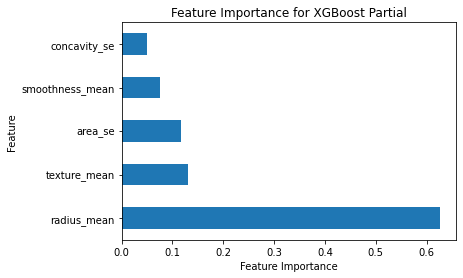

In [53]:
feat_importances_rf_p = pd.Series(model_xgb_p.feature_importances_, index=X_train_p.columns)
feat_importances_rf_p.nlargest(5).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title("Feature Importance for XGBoost Partial")

The difference is noticeable with the full datasets.  While the top seem to be the same variables, their order and level of importance is drastically different.

#### Visualizing and comparing the data

Now that all the scores have been made, it's a good time to compare them to each other visually in order to get a better idea of what's better.  I will also load the data from the baseline linear regression models to compare.

In [54]:
#Logistic regression accuracy score and roc score
accuracy_roc_score_lr_f = pd.read_csv('lr_full_scores.csv', index_col=0)
accuracy_roc_score_lr_p = pd.read_csv('lr_part_scores.csv', index_col=0)

#Divide these scores back into accuracy and roc for ease of graphing
accuracy_score_lr_f = accuracy_roc_score_lr_f['accuracy_score_lr_full']
roc_score_lr_f = accuracy_roc_score_lr_f['roc_score_f']

accuracy_score_lr_p = accuracy_roc_score_lr_p['accuracy_score_lr_part']
roc_score_lr_p = accuracy_roc_score_lr_p['roc_score_p']

In [55]:
#Classification reports for Logistic Regression
class_rep_lr_f = pd.read_csv('class_rep_f.csv', index_col=0)
class_rep_lr_p = pd.read_csv('class_rep_p.csv', index_col=0)

In [56]:
#Confusion matrices for Logistic Regression
lr_f_confusion_matrix = pd.read_csv('lr_full_conf_matrix.csv', index_col=0)
lr_p_confusion_matrix = pd.read_csv('lr_part_conf_matrix.csv', index_col=0)

We are going to focus on the targeted metrics for the models that were established earlier.  As a refresher, they are: <br>
1. Accuracy of at least 97% <br>
2. Less than 2 % false negatives <br>
3. A recall of at least 95% <br>
4. AUC of at least 99%

I'll graph each of these and see which ones, if any, 1. have a higher accuracy than the baseline model, and 2. meet the targeted metrics.  First we will graph the accuracy. 

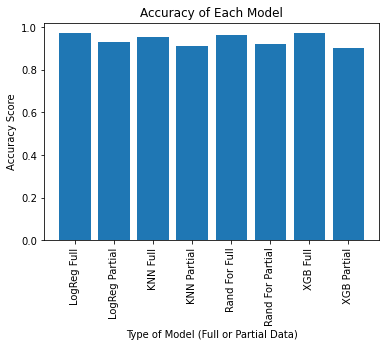

In [57]:
all_accuracies = [accuracy_score_lr_f, accuracy_score_lr_p, accuracy_score_knn_f, accuracy_score_knn_p, accuracy_score_rf_f, accuracy_score_rf_p, accuracy_score_xgb_f, accuracy_score_xgb_p]
labels = ['LogReg Full', 'LogReg Partial', 'KNN Full', 'KNN Partial', 'Rand For Full', 'Rand For Partial', 'XGB Full', 'XGB Partial']
fig,ax = plt.subplots()
acc_bar = ax.bar(labels,all_accuracies)
plt.xticks(rotation = 90)
ax.set_xlabel('Type of Model (Full or Partial Data)')
ax.set_ylabel('Accuracy Score')
ax.set_title('Accuracy of Each Model')
plt.show()

The most obvious first thing noticed is that the models with the full data consistently did better than the models with partial data.  In fact, the model that did best with partial data still was not as accurate as the model that was the worst with the full data.  Also when looking at the threshold,  logistic regression and XGBoost were the only ones that met that 97% threshold, both having the exact same accuracy.  So far, XGBoost has been the only model that is comparable to the baseline model, but all of the accuracies were high with a small difference.

We will next look at false negatives, which are how many times a tumor was malignant but got falsely classified.  This would be the worst case scenario in diagnosis, because these obviously do not want to be missed. 

In [58]:
#Take the conversion matrixes that aren plotted and make a conversion matrix where individual values can be taken.

#Confusion matrix for KNN
knn_f_conf_mat = confusion_matrix(y_test_f, y_pred_knn_f)
knn_p_conf_mat = confusion_matrix(y_test_p, y_pred_knn_p)

#Confusion matrix for Random Forest
rf_f_conf_mat = confusion_matrix(y_test_f, y_pred_rf_f)
rf_p_conf_mat = confusion_matrix(y_test_p, y_pred_rf_p)

#Confusion matrix for XGBoost
xgb_f_conf_mat = confusion_matrix(y_test_f, y_pred_xgb_f)
xgb_p_conf_mat = confusion_matrix(y_test_p, y_pred_xgb_p)

In [59]:
#For each confusion matrix, the position of false negative is at the [1,0] spot, so that will be extracted and graphed.  I can also use these extractions later in Tableau. We can also use the same labels as the last graph
false_neg_lr_f = lr_f_confusion_matrix.iloc[1,0]
false_neg_lr_p = lr_p_confusion_matrix.iloc[1,0]
false_neg_knn_f = knn_f_conf_mat[1][0]
false_neg_knn_p = knn_p_conf_mat[1][0]
false_neg_rf_f = rf_f_conf_mat[1][0]
false_neg_rf_p = rf_p_conf_mat[1][0]
false_neg_xgb_f = xgb_f_conf_mat[1][0]
false_neg_xgb_p = xgb_p_conf_mat[1][0]

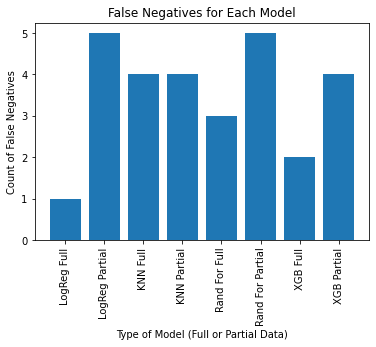

In [60]:
false_negs = [false_neg_lr_f, false_neg_lr_p, false_neg_knn_f, false_neg_knn_p, false_neg_rf_f, false_neg_rf_p, false_neg_xgb_f, false_neg_xgb_p]
fig,ax = plt.subplots()
false_neg_bar = ax.bar(labels,false_negs)
plt.xticks(rotation = 90)
ax.set_xlabel('Type of Model (Full or Partial Data)')
ax.set_ylabel('Count of False Negatives')
ax.set_title('False Negatives for Each Model')
plt.show()

This data is a little easier to differentiate.  In this case, lower numbers are better, so the logistic regression with the full data performed best, followed by the XGB Full data.  The full datasets once again performed better overall. Logistic Regression and XGBoost were once again the only models that reached the threshold.

Now we will look at the recall percentages.  The threshold here is 95%

In [61]:
#In order to extract certain features from the classification report that we need, we need to make it a dictionary.

#Classification report for KNN
class_rep_knn_f_dic = classification_report(y_test_f, y_pred_knn_f,output_dict=True)
class_rep_knn_p_dic = classification_report(y_test_p, y_pred_knn_p,output_dict=True)

#Classification report for Random Forest
class_rep_rf_f_dic = classification_report(y_test_f, y_pred_rf_f,output_dict=True)
class_rep_rf_p_dic = classification_report(y_test_p, y_pred_rf_p,output_dict=True)

#Classification report for XGBoost
class_rep_xgb_f_dic = classification_report(y_test_f, y_pred_xgb_f,output_dict=True)
class_rep_xgb_p_dic = classification_report(y_test_p, y_pred_xgb_p,output_dict=True)

In [62]:
#Now that they are all in dictionaries, I will extract the ['1']['recall'] from each in order to graph.  I can use this later in Tableau as well.
recall_lr_f = class_rep_lr_f.loc['1','recall']
recall_lr_p = class_rep_lr_p.loc['1','recall']
recall_knn_f = class_rep_knn_f_dic['1']['recall']
recall_knn_p = class_rep_knn_p_dic['1']['recall']
recall_rf_f = class_rep_rf_f_dic['1']['recall']
recall_rf_p = class_rep_rf_p_dic['1']['recall']
recall_xgb_f = class_rep_xgb_f_dic['1']['recall']
recall_xgb_p = class_rep_xgb_p_dic['1']['recall']

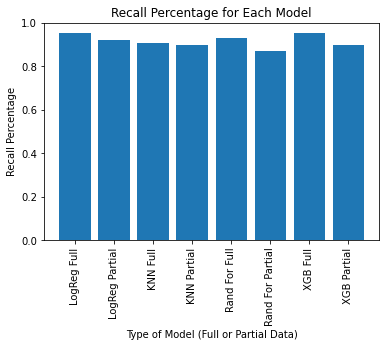

In [63]:
recall = [recall_lr_f, recall_lr_p, recall_knn_f, recall_knn_p, recall_rf_f, recall_rf_p, recall_xgb_f, recall_xgb_p]
fig,ax = plt.subplots()
false_recall = ax.bar(labels,recall)
plt.xticks(rotation = 90)
ax.set_xlabel('Type of Model (Full or Partial Data)')
ax.set_ylabel('Recall Percentage')
ax.set_title('Recall Percentage for Each Model')
plt.show()

A pattern is starting to emerge, with logistic regression and XGB full being the best, followed by Random Forest.  It's worth looking at the actual numbers of the top two to see how close they are.

In [64]:
print('Recall percentage for logistic regression: ', recall_lr_f)
print('Recall percentage for XGBoost: ', recall_xgb_f)

Recall percentage for logistic regression:  0.9534883720930232
Recall percentage for XGBoost:  0.9534883720930233


They are the exact same and are the only ones that meet the threshold.

We are to our final targeted metric, the AUC.  Fortunately this won't take more extracting than has already been done.  The threshold is 99%

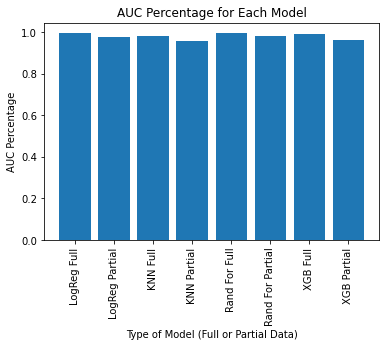

In [65]:
auc_scores = [roc_score_lr_f, roc_score_lr_p, roc_score_knn_f, roc_score_knn_p, roc_score_rf_f, roc_score_rf_p, roc_score_xgb_f, roc_score_xgb_p]

fig,ax = plt.subplots()
false_auc = ax.bar(labels,auc_scores)
plt.xticks(rotation = 90)
ax.set_xlabel('Type of Model (Full or Partial Data)')
ax.set_ylabel('AUC Percentage')
ax.set_title('AUC Percentage for Each Model')
plt.show()

This one is a little harder to tell by just looking at the graph, but I can tell that the full models have been consistently higher.  Let's look at their actual values to compare.

In [66]:
print('AUC for logistic regression: ', roc_score_lr_f)
print('AUC for KNN: ', roc_score_knn_f)
print('AUC for Random Foreset: ', roc_score_rf_f)
print('AUC for XGBoost: ', roc_score_xgb_f)

AUC for logistic regression:  0    0.995087
Name: roc_score_f, dtype: float64
AUC for KNN:  0.9787094660989191
AUC for Random Foreset:  0.9955781198820832
AUC for XGBoost:  0.9927939731411726


#### Model Conclusion

Logistic Regression, Random Forest, and XGBoost all meet the threshold, with Logistic Regression and Random Forest being slightly better than XGBoost.  However the difference was negligible.  Of the four factors that I measured, I considered the count of false negatives and the recall the two most important because I believe that the most important factor in diagnosing if a tumor is malignant or benign is making sure that we don't miss the malignant diagnosis.  The only difference between Logistic Regression base model and XGBoost is that XGBoost had one more false negative.  It is difficult to tell how significant this is, or if it is at all.  Ideally more data would needed to be collected to compare, but XGBoost is the acceptable model for the threshold given.

#### Saving the results

I would like to do more visualization of the scores collected using Tableau, so I am going to save the imporant information in a way I can use for later.

In [67]:
#Saving the accuracies, using data from above
acc_dic = dict(zip(labels, all_accuracies))
accuracies = pd.DataFrame(acc_dic).to_csv("accuracies.csv")

In [68]:
#Saving the false negatives from confusion matrixes
false_neg_dic = dict(zip(labels, false_negs))
false_negatives = pd.DataFrame(acc_dic).to_csv("false_negatives.csv")

In [69]:
#Saving the recall percentage
recall_dic = dict(zip(labels, recall))
recall = pd.DataFrame(recall_dic, index=[0]).to_csv("recall.csv")

In [70]:
#Saving the AUC
auc_dic = dict(zip(labels, auc_scores))
auc = pd.DataFrame(auc_dic).to_csv('auc.csv')

In [90]:
#I want the prediction probability for use in tableau, so I will do that

#KNN
y_pred_proba_knn_f = knn_f.predict_proba(X_test_f)[:, 1]
pd.DataFrame(y_pred_proba_knn_f).to_csv('y_pred_proba_knn_f.csv')

y_pred_proba_knn_p = knn_p.predict_proba(X_test_p)[:, 1]
pd.DataFrame(y_pred_proba_knn_p).to_csv('y_pred_proba_knn_p.csv')

#Random Forest
y_pred_proba_rf_f = rf_f.predict_proba(X_test_f)[:, 1]
pd.DataFrame(y_pred_proba_rf_f).to_csv('y_pred_proba_rf_f.csv')

y_pred_proba_rf_p = rf_p.predict_proba(X_test_p)[:, 1]
pd.DataFrame(y_pred_proba_rf_p).to_csv('y_pred_proba_rf_p.csv')

#XGBoost
y_pred_proba_xgb_f = xgb_f.predict_proba(X_test_f)[:, 1]
pd.DataFrame(y_pred_proba_xgb_f).to_csv('y_pred_proba_xgb_f.csv')

y_pred_proba_xgb_p = xgb_p.predict_proba(X_test_p)[:, 1]
pd.DataFrame(y_pred_proba_xgb_p).to_csv('y_pred_proba_xgb_p.csv')

In [87]:
#In order to match the columns of the test group to the prediction, I have to make matching ordered columns, then I will save them
y_test_f['ordered_number'] = range(0, len(y_test_f))
y_test_f

,diagnosis_num,ordered_number
id,,
87930,0,0
859575,1,1
8670,1,2
907915,0,3
921385,0,4
...,...,...
913102,0,109
8610404,1,110
884689,0,111


In [92]:
y_test_f.to_csv('y_test_f_ordered.csv')

In [88]:
y_test_p['ordered_number'] = range(0, len(y_test_p))
y_test_p

,diagnosis_num,ordered_number
id,,
9113239,0,0
925311,0,1
854253,1,2
85715,1,3
869104,1,4
...,...,...
869224,0,109
90401601,0,110
90944601,0,111


In [91]:
y_test_p.to_csv('y_test_p_ordered.csv')